# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../data/input/input_dataset.csv')

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsConceded,HTGoalsDiff,Points,WinPercent,WinStreak,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,PromotedMatchup,WinnerOdd,DrawOdd,Venue,Result
0,L Probert,Sat,1.0,-4,10.4,6.6,3.8,-1.8,0.0,0.0,0.8,0.4,2.0,0.0,0.4,-2.0,0.4,20.0,0.0,0.0,1.0,7,8,8,7.67,-12,0,-9.71,5.50,Etihad Stadium,W
1,M Halsey,Sat,1.0,1,-1.0,-0.2,0.0,-1.8,0.4,0.0,0.2,0.0,1.0,0.4,0.2,1.0,-0.2,0.0,0.0,-20.0,-1.0,1,1,-2,0.00,1,0,-2.25,3.30,Bet365 Stadium,D
2,L Mason,Sat,1.0,0,6.8,5.0,1.8,-0.2,0.4,0.2,1.6,0.6,5.0,1.4,1.0,2.0,0.4,0.0,0.0,40.0,7.0,3,0,-1,0.67,-6,0,-6.56,4.20,Goodison Park,W
3,L Probert,Sun,1.0,0,3.4,2.2,2.0,0.2,-0.6,0.0,1.8,0.6,6.0,0.4,0.4,0.0,1.0,20.0,0.0,60.0,5.0,1,2,1,1.34,-4,0,-3.58,3.75,Craven Cottage,L
4,P Dowd,Sun,1.0,-1,-2.4,-1.8,-0.6,0.6,-1.0,0.0,-0.4,-1.2,4.0,0.2,0.0,1.0,1.0,20.0,0.0,60.0,6.0,-1,-3,-5,-3.00,-1,0,-1.50,3.30,Carrow Road,W


In [4]:
# label encode categorical feature- Day Of Week
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode categorical feature- Referee
referee_le = LabelEncoder()
df['Referee'] = referee_le.fit_transform(df['Referee'])

# label encode categorical feature- Venue
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

# 3. Feature Selection

In [5]:
selected_features = ['Shots', 'Corners', 'Points', 'UnbStreak', 'LastSeasonRank', 'Venue']

# 4. Model Building- Data Split 7

- Target Variable: Win/ Non-Win
- Stratified Sampling

### Random Forest Classifier

#### Hyperparameter Tuning using Fold 1

In [6]:
# data splitting
train_set = pd.read_csv('./fold-1/train.csv')
test_set = pd.read_csv('./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}


#### Fold 1

In [10]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv('./fold-1/train.csv')
test_set = pd.read_csv('./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


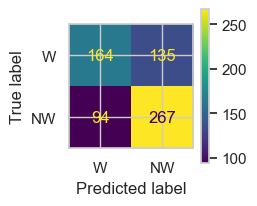

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [12]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6530303030303031
ROC score on Test Set: 0.7121059116723335

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       299
           1       0.66      0.74      0.70       361

    accuracy                           0.65       660
   macro avg       0.65      0.64      0.64       660
weighted avg       0.65      0.65      0.65       660



#### Fold 2

In [13]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


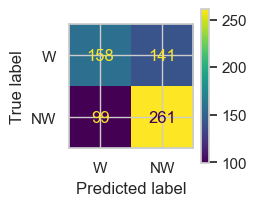

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [15]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6358118361153262
ROC score on Test Set: 0.69223337049424

              precision    recall  f1-score   support

           0       0.61      0.53      0.57       299
           1       0.65      0.72      0.69       360

    accuracy                           0.64       659
   macro avg       0.63      0.63      0.63       659
weighted avg       0.63      0.64      0.63       659



#### Fold 3

In [16]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


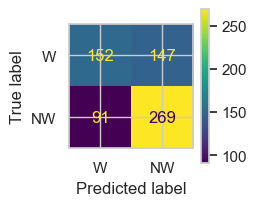

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6388467374810318
ROC score on Test Set: 0.6932367149758454

              precision    recall  f1-score   support

           0       0.63      0.51      0.56       299
           1       0.65      0.75      0.69       360

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.63       659
weighted avg       0.64      0.64      0.63       659



#### Fold 4

In [19]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


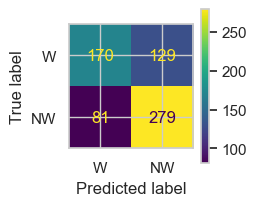

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [21]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6813353566009105
ROC score on Test Set: 0.7010126347082868

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       299
           1       0.68      0.78      0.73       360

    accuracy                           0.68       659
   macro avg       0.68      0.67      0.67       659
weighted avg       0.68      0.68      0.68       659



#### Fold 5

In [22]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt', n_estimators=200, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])
print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


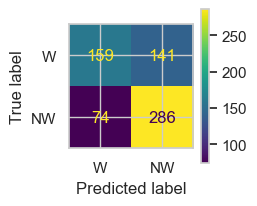

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6742424242424242
ROC score on Test Set: 0.7439166666666668

              precision    recall  f1-score   support

           0       0.68      0.53      0.60       300
           1       0.67      0.79      0.73       360

    accuracy                           0.67       660
   macro avg       0.68      0.66      0.66       660
weighted avg       0.68      0.67      0.67       660



### Logistic Regression

#### Hyperparameter Tuning using Fold 1

In [8]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.03359818286283781, 'penalty': 'l1', 'solver': 'liblinear'}


#### Fold 1

In [25]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


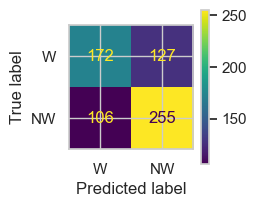

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [27]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.646969696969697
ROC score on Test Set: 0.7112813718859726

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       299
           1       0.67      0.71      0.69       361

    accuracy                           0.65       660
   macro avg       0.64      0.64      0.64       660
weighted avg       0.65      0.65      0.65       660



#### Fold 2

In [28]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


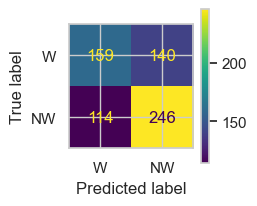

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [30]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6145675265553869
ROC score on Test Set: 0.6772761055369751

              precision    recall  f1-score   support

           0       0.58      0.53      0.56       299
           1       0.64      0.68      0.66       360

    accuracy                           0.61       659
   macro avg       0.61      0.61      0.61       659
weighted avg       0.61      0.61      0.61       659



#### Fold 3

In [31]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


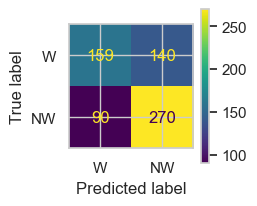

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [33]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6509863429438544
ROC score on Test Set: 0.695224823485693

              precision    recall  f1-score   support

           0       0.64      0.53      0.58       299
           1       0.66      0.75      0.70       360

    accuracy                           0.65       659
   macro avg       0.65      0.64      0.64       659
weighted avg       0.65      0.65      0.65       659



#### Fold 4

In [34]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


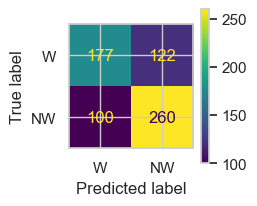

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [36]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6631259484066768
ROC score on Test Set: 0.7097175771088814

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       299
           1       0.68      0.72      0.70       360

    accuracy                           0.66       659
   macro avg       0.66      0.66      0.66       659
weighted avg       0.66      0.66      0.66       659



#### Fold 5

In [37]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


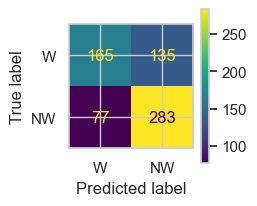

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [39]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6787878787878788
ROC score on Test Set: 0.7371296296296297

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       300
           1       0.68      0.79      0.73       360

    accuracy                           0.68       660
   macro avg       0.68      0.67      0.67       660
weighted avg       0.68      0.68      0.67       660



### SVM Classifier

#### Hyperparameter Tuning using Fold 1

In [9]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 1, 'tol': 0.1}


#### Fold 1

In [40]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


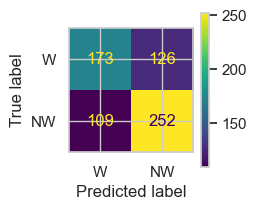

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [42]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6439393939393939
ROC score on Test Set: 0.7004048582995951

              precision    recall  f1-score   support

           0       0.61      0.58      0.60       299
           1       0.67      0.70      0.68       361

    accuracy                           0.64       660
   macro avg       0.64      0.64      0.64       660
weighted avg       0.64      0.64      0.64       660



#### Fold 2

In [43]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=0.1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


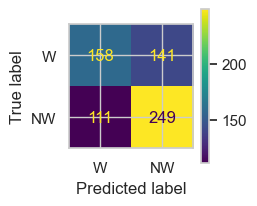

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [45]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6176024279210925
ROC score on Test Set: 0.6727889260497956

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       299
           1       0.64      0.69      0.66       360

    accuracy                           0.62       659
   macro avg       0.61      0.61      0.61       659
weighted avg       0.62      0.62      0.62       659



#### Fold 3

In [46]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=0.1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


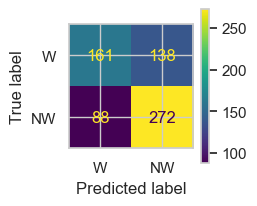

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [48]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6570561456752656
ROC score on Test Set: 0.7038647342995168

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       299
           1       0.66      0.76      0.71       360

    accuracy                           0.66       659
   macro avg       0.66      0.65      0.65       659
weighted avg       0.66      0.66      0.65       659



#### Fold 4

In [49]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=0.1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


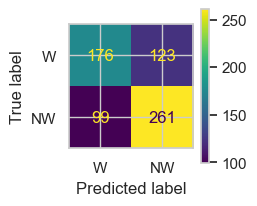

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [51]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6631259484066768
ROC score on Test Set: 0.7017186919360833

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       299
           1       0.68      0.72      0.70       360

    accuracy                           0.66       659
   macro avg       0.66      0.66      0.66       659
weighted avg       0.66      0.66      0.66       659



#### Fold 5

In [52]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=0.1, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


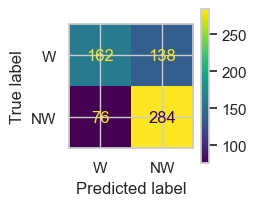

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [54]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6757575757575758
ROC score on Test Set: 0.7397962962962963

              precision    recall  f1-score   support

           0       0.68      0.54      0.60       300
           1       0.67      0.79      0.73       360

    accuracy                           0.68       660
   macro avg       0.68      0.66      0.66       660
weighted avg       0.68      0.68      0.67       660



### XGBoost Classifier

#### Hyperparameter Tuning using Fold 1

In [7]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 180}


#### Fold 1

In [55]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=180)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


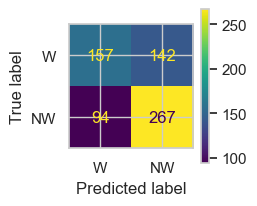

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [57]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6424242424242425
ROC score on Test Set: 0.7059172310286366

              precision    recall  f1-score   support

           0       0.63      0.53      0.57       299
           1       0.65      0.74      0.69       361

    accuracy                           0.64       660
   macro avg       0.64      0.63      0.63       660
weighted avg       0.64      0.64      0.64       660



#### Fold 2

In [58]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=180)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


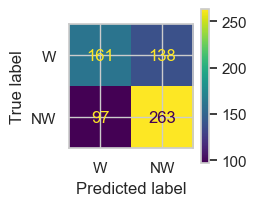

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [60]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6433990895295902
ROC score on Test Set: 0.6917688591601636

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       299
           1       0.66      0.73      0.69       360

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.63       659
weighted avg       0.64      0.64      0.64       659



#### Fold 3

In [61]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=180)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


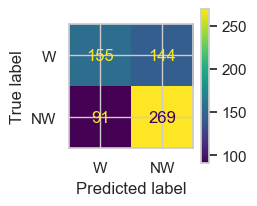

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [63]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6433990895295902
ROC score on Test Set: 0.6877926421404681

              precision    recall  f1-score   support

           0       0.63      0.52      0.57       299
           1       0.65      0.75      0.70       360

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.63       659
weighted avg       0.64      0.64      0.64       659



#### Fold 4

In [64]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=180)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


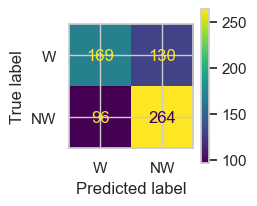

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [66]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6570561456752656
ROC score on Test Set: 0.6981280193236715

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       299
           1       0.67      0.73      0.70       360

    accuracy                           0.66       659
   macro avg       0.65      0.65      0.65       659
weighted avg       0.66      0.66      0.65       659



#### Fold 5

In [67]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=180)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


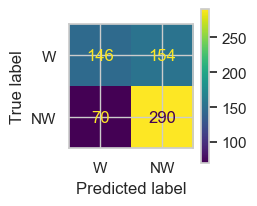

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [69]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6606060606060606
ROC score on Test Set: 0.733587962962963

              precision    recall  f1-score   support

           0       0.68      0.49      0.57       300
           1       0.65      0.81      0.72       360

    accuracy                           0.66       660
   macro avg       0.66      0.65      0.64       660
weighted avg       0.66      0.66      0.65       660

